In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from pennylane import numpy as np 

import DRU_library
from DRU_library import base_functions as model_dru
from DRU_library import training as model_fit 
from DRU_library import cost_functions
from DRU_library import evaluation as ev

In [2]:
# -----------------------
# Carga del dataset Iris
# -----------------------

iris = load_iris()
x = iris.data
y = iris.target

print("Número de clases:", len(np.unique(y)))
print("Número de características originales:", x.shape[1])

# -----------------------
# Reducción de dimensión con PCA
# -----------------------
pca = PCA(n_components=3)  # Reducción a 3 características principales
x_pca = pca.fit_transform(x)
caracteristicas = x_pca.shape[1]
print("Número de características después de PCA:", x_pca.shape[1])
print("Varianza explicada por las 3 componentes:", np.sum(pca.explained_variance_ratio_))

# -----------------------
# División en entrenamiento y validación
# -----------------------
X_train, X_val, y_train, y_val = train_test_split(x_pca, y, test_size=0.2, random_state=1)

# -----------------------
# Escalado para codificación cuántica
# -----------------------
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)


Número de clases: 3
Número de características originales: 4
Número de características después de PCA: 3
Varianza explicada por las 3 componentes: 0.9947878161267252


In [3]:
#prueba de con un circuito pequeño 

modelo_2 = model_dru.circuito_parametrico(capas=1, qubits=1, entrelazamiento='No')  #una capa DRU 1 qubit

In [4]:
#partametros
w,thethe = model_dru.parametros(1,1,3,1)
x = np.array([1,2,3])

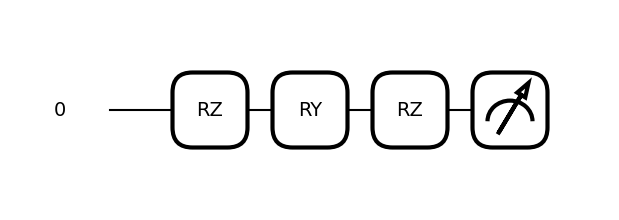

In [5]:
#dibujo
model_dru.dibujar_modelo_completo(modelo_2,np.array([1,2,3]),thethe,w)

In [6]:
#ejecucion del q-node
modelo_2(x,thethe,w)

tensor([0.11584199+0.96462862j, 0.21280361+0.10385991j], requires_grad=True)

#modelo_1  sin entrelazamiento


In [7]:
#modelo de entrenamiento 1: 4 capaz DRU 2 qubits sin entrelazamiento 
np.random.seed(0)
etiquetas_ket, etiquetas_modelo_1 = model_dru.generar_etiquetas(len(np.unique(y)))
modelo_1 = model_dru.circuito_parametrico(capas=4, qubits=2, entrelazamiento='No')
_,subcapas = model_dru.re_dim(X_val[0])
theta, w = model_dru.parametros(subcapas, capas=4, qubits=2)
params_originales = [theta, w]
params_flat, shape_flat = model_dru.flatten_params(params_originales)
params_flat = np.array(params_flat, requires_grad=True)

NUMERO SUGERIDO DE QUBITS 2


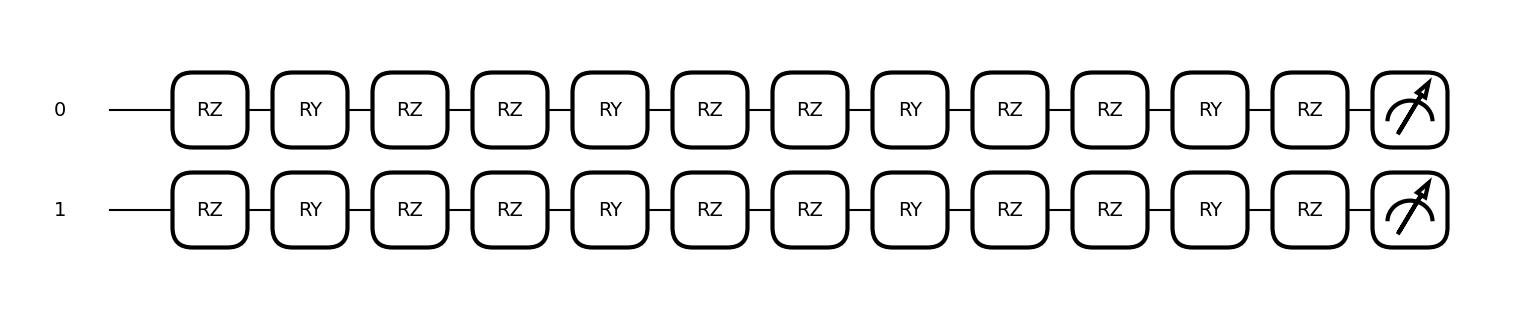

In [8]:
model_dru.dibujar_modelo_completo(modelo_1,X_train[0],theta,w)

In [9]:
#enetrenamiento con modelo de una capa 
best_params, historia = model_fit.fit(modelo_1, etiquetas_modelo_1,X_train, y_train, X_val, y_val,params_flat, shape_flat,cost_function=cost_functions.Renyi_Divergence_0_5)

Entrenando:  31%|███       | 155/500 [17:37<39:14,  6.82s/epoch, Loss=0.2265, Train acc=96.67%, Val acc=86.67%, Best loss=0.2112, Best val acc=90.00%, wait=93] 

=====> mejor acierto: 100.00% | mejor costo: 0.2673


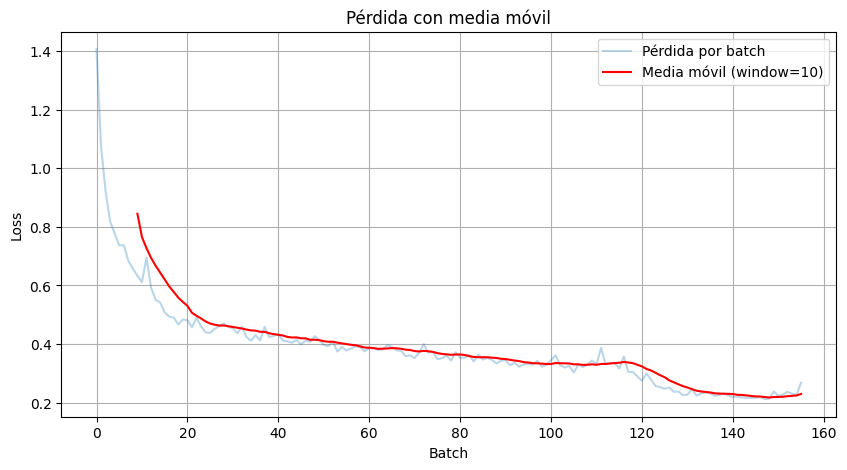

In [10]:
ev.plot_loss_curve(historia['loss'], window=10)

In [11]:
pre = ev.predict
pre_proba = ev.predict_proba

ev.evaluate_classification(
    modelo=modelo_1,
    best_params=best_params,
    shape_flat=shape_flat,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    predict=pre,
    predict_proba=pre_proba
)

=== Métricas en conjunto de entrenamiento ===
[[39  0  0]
 [ 0 33  3]
 [ 0  0 44]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      0.89      0.94        37
           2       0.94      1.00      0.97        44

   micro avg       0.97      0.97      0.97       120
   macro avg       0.98      0.96      0.97       120
weighted avg       0.98      0.97      0.97       120


=== Métricas en conjunto de validación ===
[[11  0  0]
 [ 0 10  2]
 [ 0  0  6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.77      0.87        13
           2       0.75      1.00      0.86         6

   micro avg       0.93      0.90      0.92        30
   macro avg       0.92      0.92      0.91        30
weighted avg       0.95      0.90      0.91        30


Curva ROC no disponible (multiclase o falta de predict_proba).
